In [1]:
# Remote data access for pandas
import pandas_datareader as webreader
# Mathematical functions 
import math 
# Fundamental package for scientific computing with Python
import numpy as np 
# Additional functions for analysing and manipulating data
import pandas as pd 
# Date Functions
from datetime import date, timedelta
# This function adds plotting functions for calender dates
from pandas.plotting import register_matplotlib_converters
# Important package for visualization - we use this to plot the market data
import matplotlib.pyplot as plt 
# Formatting dates
import matplotlib.dates as mdates
# Packages for measuring model performance / errors
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Tools for predictive data analysis. We will use the MinMaxScaler to normalize the price data 
from sklearn.preprocessing import MinMaxScaler 
# Deep learning library, used for neural networks
from keras.models import Sequential 
# Deep learning classes for recurrent and regular densely-connected layers
from keras.layers import LSTM, Dense

Using TensorFlow backend.


# Loading the data

In [2]:
# Setting the timeframe for the data extraction
today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = '2010-01-01'

# Getting S&P500 quotes
stockname = 'S&P500'
symbol = '^GSPC'
df = webreader.DataReader(
    symbol, start=date_start, end=date_today, data_source="yahoo"
)

# Taking a look at the shape of the dataset
print(df.shape)
df.head(5)

(2616, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,1133.869995,1116.560059,1116.560059,1132.989990,3991400000,1132.989990
2010-01-05,1136.630005,1129.660034,1132.660034,1136.520020,2491020000,1136.520020
2010-01-06,1139.189941,1133.949951,1135.709961,1137.140015,4972660000,1137.140015
2010-01-07,1142.459961,1131.319946,1136.270020,1141.689941,5270680000,1141.689941
2010-01-08,1145.390015,1136.219971,1140.520020,1144.979980,4389590000,1144.979980


# Exploring the data

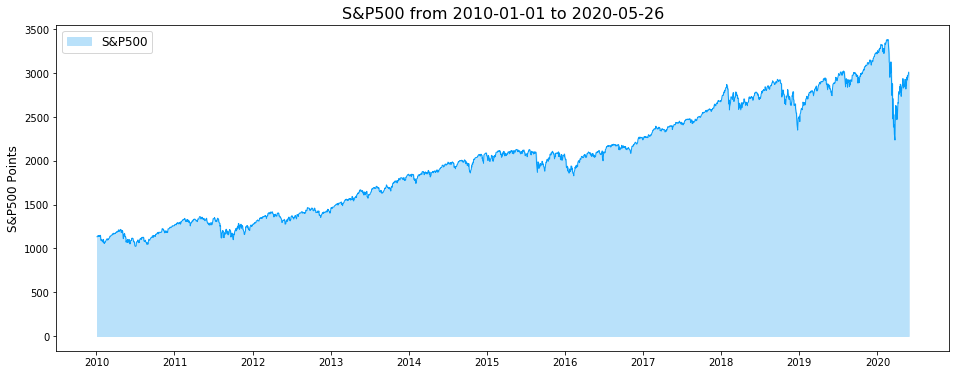

In [3]:
# Plotting the data
register_matplotlib_converters()
years = mdates.YearLocator() 
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.xaxis.set_major_locator(years)
x = df.index
y = df['Close']
ax1.fill_between(x, 0, y, color='#b9e1fa')
ax1.legend([stockname], fontsize=12)
plt.title(stockname + ' from '+ date_start + ' to ' + date_today, fontsize=16)
plt.plot(y, color='#039dfc', label=stockname, linewidth=1.0)
plt.ylabel('S&P500 Points', fontsize=12)
plt.show()

# Preprocessing

In [4]:
# Create a new dataframe with only the Close column and convert to numpy array
data = df.filter(['Close'])
npdataset = data.values

# Get the number of rows to train the model on 80% of the data 
training_data_length = math.ceil(len(npdataset) * 0.8)

# Transform features by scaling each feature to a range between 0 and 1
mmscaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = mmscaler.fit_transform(npdataset)
scaled_data

array([[0.04671323],
       [0.04820674],
       [0.04846905],
       ...,
       [0.81483945],
       [0.81777566],
       [0.84161253]])

In [10]:
# Create a scaled training data set
train_data = scaled_data[0:training_data_length, :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []
trainingdatasize = len(train_data) 
for i in range(100, trainingdatasize):
    x_train.append(train_data[i-100: i, 0]) #contains 100 values 0-100
    y_train.append(train_data[i, 0]) #contains all other values

# Convert the x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)
print(y_train.shape)
print(x_train[0][1][0], y_train[1])

(1993, 100, 1)
(1993,)
0.04820674148552467 0.028275033248134518


# Model Training

In [8]:
# Configure the neural network model
model = Sequential()

# Model with 100 Neurons 
# inputshape = 100 Timestamps
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1))) 
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [9]:
# Training the model
model.fit(x_train, y_train, batch_size=16, epochs=25)

Epoch 1/25
1977/1977 [==============================] - 19s 10ms/step - loss: 0.0053
Epoch 2/25
1977/1977 [==============================] - 22s 11ms/step - loss: 2.1645e-04
Epoch 3/25
1977/1977 [==============================] - 20s 10ms/step - loss: 2.7839e-04
Epoch 4/25
1977/1977 [==============================] - 20s 10ms/step - loss: 2.5515e-04
Epoch 5/25
1977/1977 [==============================] - 21s 11ms/step - loss: 2.1196e-04
Epoch 6/25
1977/1977 [==============================] - 21s 11ms/step - loss: 2.1716e-04
Epoch 7/25
1977/1977 [==============================] - 21s 11ms/step - loss: 2.2461e-04
Epoch 8/25
1977/1977 [==============================] - 22s 11ms/step - loss: 1.9997e-04 2s - los
Epoch 9/25
1977/1977 [==============================] - 22s 11ms/step - loss: 1.8823e-04
Epoch 10/25
1977/1977 [==============================] - 22s 11ms/step - loss: 1.8772e-04
Epoch 11/25
1977/1977 [==============================] - 22s 11ms/step - loss: 1.8190e-04
Epoch 12/25
19

In [73]:
# Create a new array containing scaled test values
test_data = scaled_data[training_data_length - 100:, :]

# Create the data sets x_test and y_test
x_test = []
y_test = npdataset[training_data_length:, :]
for i in range(100, len(test_data)):
    x_test.append(test_data[i-100:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data, so that we get an array with multiple test datasets
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [11]:
# Get the predicted values
predictions = model.predict(x_test)
predictions = mmscaler.inverse_transform(predictions)

# Evaluate model performance

In [72]:
# Calculate the mean absolute error (MAE)
mae = mean_absolute_error(predictions, y_test)
print('MAE: ' + str(round(mae, 1)))

# Calculate the root mean squarred error (RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('RMSE: ' + str(round(rmse, 1)))

MAE: 32.0
RMSE: 17.6


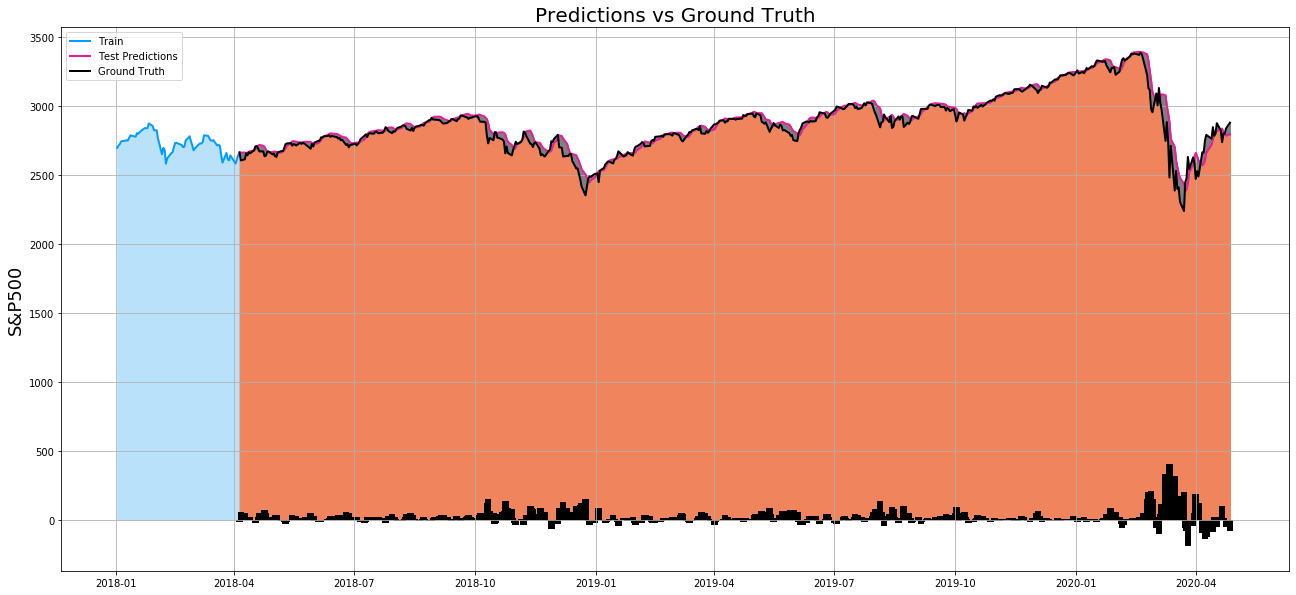

In [74]:
# The date from which on the date is displayed
display_start_date = "2018-01-01" 

# Add the difference between the valid and predicted prices
train = data[:training_data_length + 1]
valid = data[training_data_length:]
valid.insert(1, "Predictions", predictions, True)
valid.insert(1, "Difference", valid["Predictions"] - valid["Close"], True)

# Zoom in to a closer timeframe
valid = valid[valid.index > display_start_date]
train = train[train.index > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train.index; yt = train[["Close"]]
xv = valid.index; yv = valid[["Close", "Predictions"]]
plt.title("Predictions vs Ground Truth", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(yt, color="#039dfc", linewidth=2.0)
plt.plot(yv["Predictions"], color="#E91D9E", linewidth=2.0)
plt.plot(yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Ground Truth"], loc="upper left")

# Fill between plotlines
ax1.fill_between(xt, 0, yt["Close"], color="#b9e1fa")
ax1.fill_between(xv, 0, yv["Predictions"], color="#F0845C")
ax1.fill_between(xv, yv["Close"], yv["Predictions"], color="grey") 

# Create the bar plot with the differences
x = valid.index
y = valid["Difference"]
plt.bar(x, y, width=5, color="black")
plt.grid()
plt.show()

In [23]:
# Show the valid and predicted prices
dif = valid['Close'] - valid['Predictions']
valid.insert(2, 'Difference', dif, True)
valid.tail(5)

,Close,Difference,Difference,Difference,Predictions
Date,,,,,
2018-04-05,2662.840088,-19.042480,19.042480,19.042480,2643.797607
2018-04-06,2604.469971,56.504639,-56.504639,-56.504639,2660.974609
2018-04-09,2613.159912,48.466064,-48.466064,-48.466064,2661.625977
2018-04-10,2656.870117,0.113281,-0.113281,-0.113281,2656.983398
2018-04-11,2642.189941,19.454102,-19.454102,-19.454102,2661.644043


# Predict next day's price

In [60]:
# Get fresh data until today and create a new dataframe with only the price data
price_quote = webreader.DataReader(symbol, data_source='yahoo', start=date_start, end=date_today)
new_df = price_quote.filter(['Close'])

# Get the last 100 day closing price values and scale the data to be values between 0 and 1
last_100_days = new_df[-100:].values
last_100_days_scaled = mmscaler.transform(new_df[-100:].values)

# Create an empty list and Append past 100 days
X_test = []
X_test.append(last_100_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price, undo the scaling and output the predictions
pred_price = model.predict(X_test)
pred_price = mmscaler.inverse_transform(pred_price)
date_tomorrow = date.today() + timedelta(days=1)
print('The price for ' + stockname + ' at ' + date_today + ' was: ' + str(round(df.at[df.index.max(), 'Close'])))
print('The predicted ' + stockname + ' price at date ' + str(date_tomorrow) + ' is: ' + str(round(pred_price[0, 0], 0)))

The price for S&P500 at 2020-04-28 was: 2878.0
The predicted S&P500 price at date 2020-04-29 is: 2820.0
